In [3]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv(r"D:\Nam 4\Ki 1\Lap trinh cho KHDL\Final Project\LTKHDL\data\cleaned_data.csv")
df.head(5)

,age,sex,race,marital_status,education,employment_status,income_level,books_read_last_12m,read_printed_books_last_12m,read_audiobooks_last_12m,read_ebooks_last_12m,last_book_read_format,read_daily_news,read_magazines_journals
0,66,Male,Refused,Divorced,College graduate,Retired,3,97,Yes,No,Yes,Purchased the book,No,Yes
1,46,Male,Native American/American Indian,Married,High school graduate,Employed full-time,1,97,Yes,Yes,Yes,Purchased the book,Yes,Yes
2,32,Male,Mixed race,Never been married,High school graduate,Employed full-time,1,97,No,Yes,Yes,Borrowed the book from a friend or family member,Yes,Yes
3,27,Male,Mixed race,Married,High school graduate,Employed full-time,5,97,Yes,No,Yes,Borrowed the book from a library,Yes,No
4,16,Female,Mixed race,Never been married,High school incomplete,Employed part-time,2,97,Yes,Yes,No,Purchased the book,Yes,No


## Câu hỏi khai thác insight data

### Câu 1. Mối quan hệ giữa độ tuổi và hành vi đọc sách

* Câu hỏi: Độ tuổi ảnh hưởng như thế nào đến hành vi đọc sách in, sách nói và sách điện tử? Có phải người trẻ tuổi thích sách điện tử hơn, trong khi người lớn tuổi thích sách in không?
* Ý nghĩa thu được: Hiểu được thói quen đọc sách theo độ tuổi giúp đưa ra các chiến lược tiếp thị phù hợp với từng nhóm tuổi.

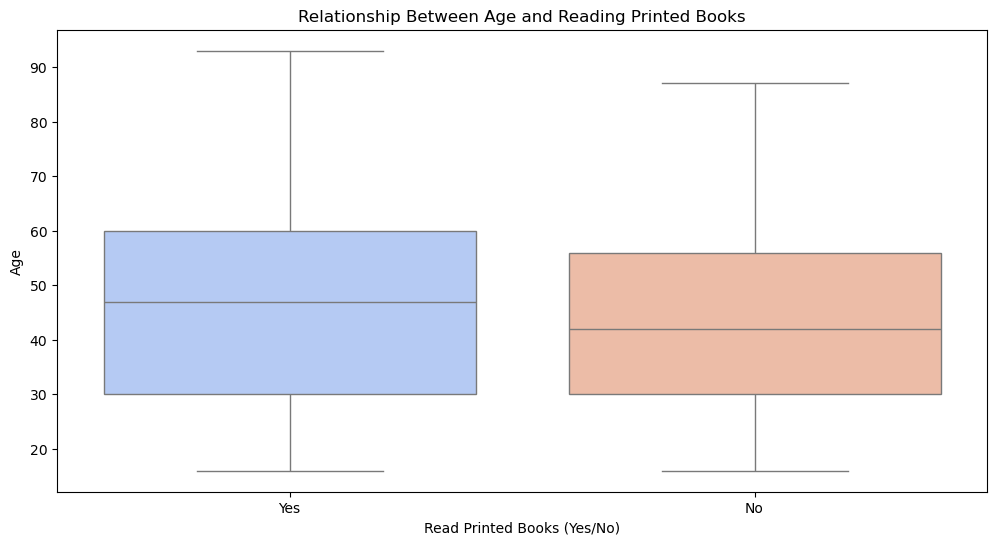

In [5]:
# Biểu đồ boxplot để xem số lượng sách đọc theo độ tuổi và định dạng
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='read_printed_books_last_12m', y='age', palette='coolwarm')
plt.title('Relationship Between Age and Reading Printed Books')
plt.xlabel('Read Printed Books (Yes/No)')
plt.ylabel('Age')
plt.show()

**Nhận xét**: 
Biểu đồ boxplot cho thấy mối quan hệ rõ rệt giữa độ tuổi và thói quen đọc sách in. Cụ thể, nhóm trả lời "Yes" (có đọc sách in) có độ tuổi trung vị cao hơn, và phân phối độ tuổi rộng hơn, từ khoảng 20 đến trên 90 tuổi. Điều này cho thấy sách in phổ biến hơn ở các thế hệ lớn tuổi, những người có thể duy trì thói quen đọc truyền thống. Trong khi đó, nhóm "No" (không đọc sách in) tập trung chủ yếu ở độ tuổi trẻ và trung niên, từ 20 đến 60 tuổi, với độ phân tán thấp hơn.

Ngoài ra, nhóm "Yes" còn xuất hiện một số điểm ngoại lệ với người trên 90 tuổi, thể hiện sự gắn bó lâu dài với sách in. Nhóm "No" ít ngoại lệ, cho thấy xu hướng không đọc sách in đồng nhất hơn, có thể do sự phổ biến của định dạng kỹ thuật số như e-books hoặc audiobooks.

### Câu 2. Tác động của trình độ học vấn đến việc đọc tin tức và tạp chí

* Câu hỏi: Liệu trình độ học vấn cao hơn có dẫn đến tần suất đọc tin tức hoặc tạp chí nhiều hơn không?
* Ý nghĩa thu được: Điều này giúp xác định mức độ tác động của giáo dục đến việc cập nhật thông tin, từ đó hỗ trợ các chiến dịch giáo dục hoặc truyền thông.

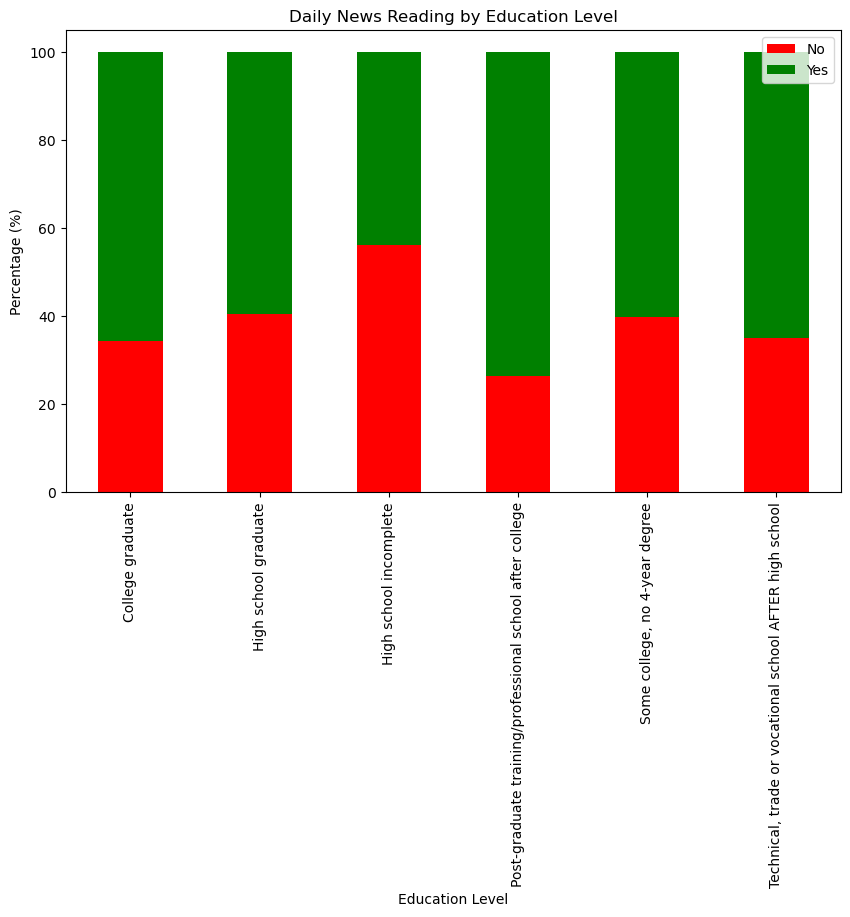

In [6]:
# Tỷ lệ đọc tin tức theo mức độ giáo dục
education_news = df.groupby('education')['read_daily_news'].value_counts(normalize=True).unstack() * 100

# Biểu đồ stacked bar chart
education_news.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])
plt.title('Daily News Reading by Education Level')
plt.ylabel('Percentage (%)')
plt.xlabel('Education Level')
plt.legend(['No', 'Yes'])
plt.show()

**Nhận xét**

Biểu đồ thể hiện mối quan hệ giữa trình độ học vấn và thói quen đọc tin tức hàng ngày cho thấy xu hướng rõ ràng: những người có trình độ học vấn cao hơn (như tốt nghiệp đại học hoặc tham gia các chương trình đào tạo sau đại học) có tỷ lệ đọc tin tức hàng ngày cao hơn so với những người có trình độ học vấn thấp hơn (như chưa hoàn thành trung học). Cụ thể:

* Nhóm có học vấn cao: Tỷ lệ đọc tin tức hàng ngày (màu xanh) chiếm phần lớn, cho thấy mối liên hệ tích cực giữa trình độ học vấn và sự quan tâm đến cập nhật thông tin.
* Nhóm có học vấn thấp hơn: Tỷ lệ không đọc tin tức hàng ngày (màu đỏ) cao hơn, đặc biệt ở những người chưa hoàn thành trung học hoặc chỉ học các chương trình nghề.

### Câu 3. Mối quan hệ giữa trạng thái việc làm và thói quen đọc sách

* Câu hỏi: Trạng thái việc làm (toàn thời gian, bán thời gian, nghỉ hưu) có ảnh hưởng đến số lượng sách đọc trong 12 tháng qua không? Nếu có, nhóm nào đọc sách nhiều hơn?
* Ý nghĩa thu được: Thông tin này giúp xác định các nhóm mục tiêu cho chiến lược phân phối nội dung hoặc sản phẩm liên quan đến sách.

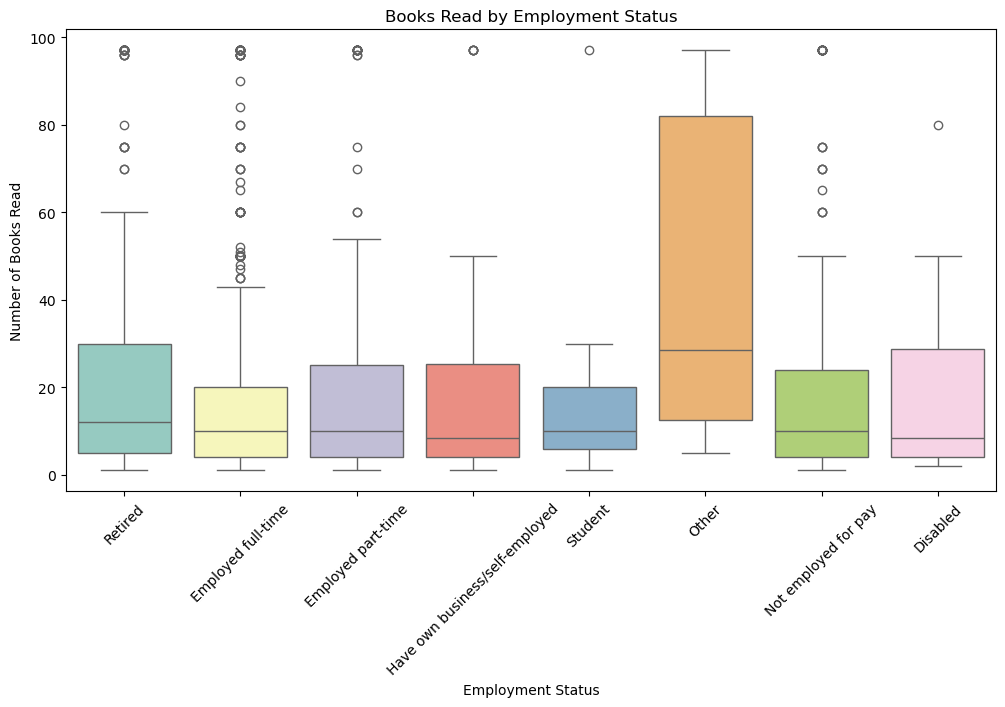

In [7]:
# Biểu đồ boxplot số sách đã đọc theo trạng thái việc làm
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='employment_status', y='books_read_last_12m', palette='Set3')
plt.title('Books Read by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Number of Books Read')
plt.xticks(rotation=45)
plt.show()

### Câu 4. Thu nhập ảnh hưởng thế nào đến định dạng sách mà mọi người mua hoặc mượn?

* Câu hỏi: Những người có mức thu nhập khác nhau có xu hướng mua sách hay mượn sách (thư viện, bạn bè) không? Liệu người có thu nhập cao thích mua sách in hoặc sách điện tử không?
* Ý nghĩa thu được: Thông tin này giúp định hướng chiến lược giá và hình thức phân phối sách (mua hoặc mượn).

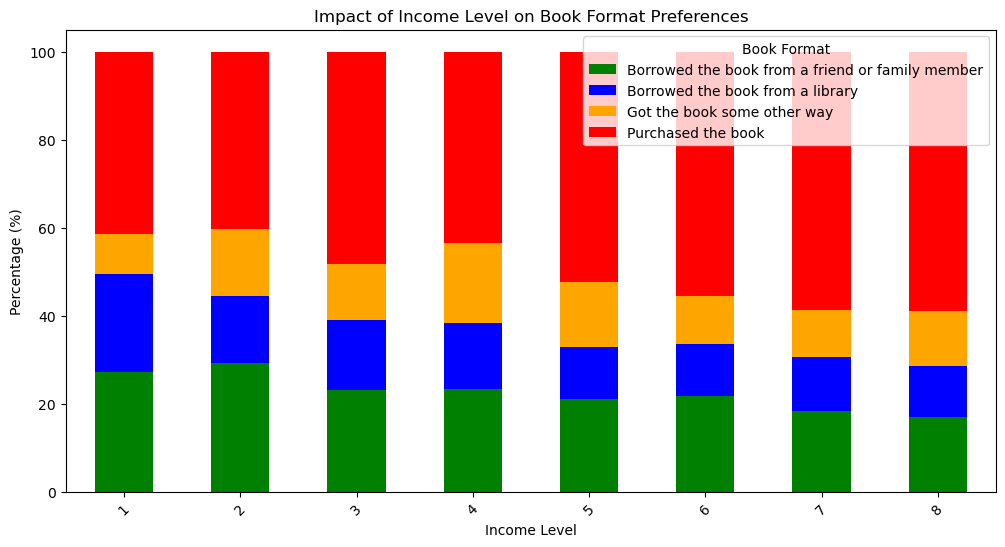

In [8]:
# Tính tỷ lệ đọc từng định dạng sách theo mức thu nhập
income_format = df.groupby('income_level')['last_book_read_format'].value_counts(normalize=True).unstack() * 100

# Biểu đồ stacked bar chart
income_format.plot(kind='bar', stacked=True, figsize=(12, 6), color=['green', 'blue', 'orange', 'red'])
plt.title('Impact of Income Level on Book Format Preferences')
plt.ylabel('Percentage (%)')
plt.xlabel('Income Level')
plt.legend(title='Book Format')
plt.xticks(rotation=45)
plt.show()

**Nhận xét**

Biểu đồ cho thấy mối quan hệ rõ rệt giữa mức thu nhập và cách mọi người tiếp cận sách. Nhìn chung, tỷ lệ người mua sách (màu đỏ) tăng dần theo mức thu nhập, đặc biệt nổi bật ở các nhóm có thu nhập cao, thể hiện rằng khả năng tài chính mạnh mẽ thúc đẩy hành vi sở hữu sách. Ngược lại, việc mượn sách từ thư viện (màu xanh lam) giảm dần khi thu nhập tăng, cho thấy nhóm có thu nhập thấp hoặc trung bình phụ thuộc nhiều hơn vào thư viện như một nguồn tiếp cận sách chi phí thấp. Hành vi mượn sách từ bạn bè hoặc gia đình (màu xanh lá cây) không có sự thay đổi đáng kể giữa các mức thu nhập, cho thấy đây là một thói quen phổ biến, không bị ảnh hưởng nhiều bởi điều kiện tài chính. Hình thức khác để có sách (màu cam) chiếm tỷ lệ thấp và giảm nhẹ ở nhóm thu nhập cao, có thể do những người này thường ưu tiên mua sách thay vì sử dụng các nguồn thay thế.

Kết quả này cho thấy, ở nhóm thu nhập cao, việc mua sách là phổ biến, thể hiện mức độ sẵn sàng chi tiêu để sở hữu sách cao cấp hoặc độc quyền. Trong khi đó, nhóm thu nhập thấp phụ thuộc nhiều hơn vào thư viện và các nguồn sách miễn phí, phản ánh vai trò quan trọng của các chương trình hỗ trợ cộng đồng. Điều này gợi ý rằng các nhà xuất bản nên tập trung cung cấp các sản phẩm cao cấp cho nhóm thu nhập cao, đồng thời duy trì và mở rộng các chương trình thư viện và sách miễn phí để hỗ trợ thói quen đọc sách ở các nhóm thu nhập thấp hơn.

### Câu 5. Thói quen đọc tin tức giữa các nhóm giới tính khác nhau

* Câu hỏi: Có sự khác biệt đáng kể giữa nam và nữ trong việc đọc tin tức hàng ngày không? Nếu có, nhóm nào cập nhật tin tức thường xuyên hơn?
* Ý nghĩa thu được: Hiểu được sự khác biệt giới tính trong hành vi đọc giúp thiết kế các chiến dịch truyền thông phù hợp.

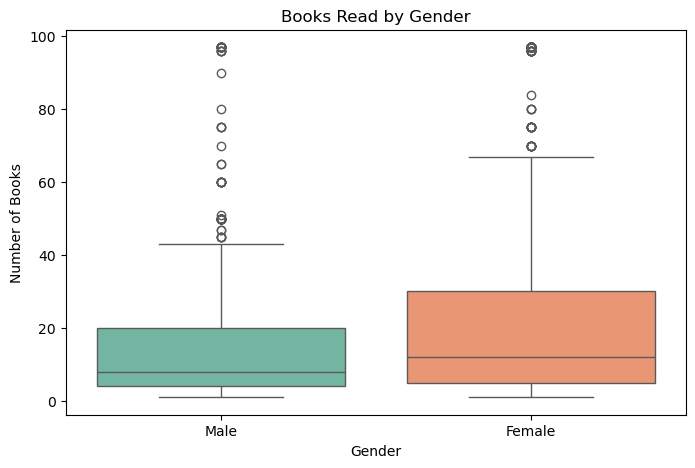

In [9]:
# Boxplot số lượng sách đọc theo giới tính
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sex', y='books_read_last_12m', palette='Set2')
plt.title('Books Read by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Books')
plt.show()

**Nhận xét**

Biểu đồ boxplot so sánh số lượng sách đọc giữa nam và nữ cho thấy những khác biệt đáng chú ý trong thói quen đọc sách của hai nhóm giới tính. Phụ nữ có phạm vi số lượng sách đọc lớn hơn nam giới, thể hiện qua chiều dài hộp và số lượng điểm ngoại lệ nhiều hơn. Trong khi đó, nam giới có xu hướng đồng nhất hơn, với số lượng sách đọc tập trung chủ yếu dưới 20 cuốn. Mặc dù trung vị số lượng sách đọc của hai nhóm khá tương đương, phụ nữ có nhiều cá nhân đọc vượt trội, đặc biệt một số trường hợp đọc trên 80 cuốn, vượt xa mức trung bình. 

Kết quả này cho thấy phụ nữ có xu hướng đọc sách đa dạng hơn về số lượng, trong khi nam giới duy trì mức độ ổn định hơn. Điều này gợi ý rằng các chiến dịch khuyến khích đọc sách hoặc tiếp thị nội dung nên được thiết kế phù hợp với từng nhóm giới tính. Đặc biệt, nhóm phụ nữ với thói quen đọc nhiều sách hơn có thể trở thành đối tượng tiềm năng cho các chiến lược tiếp thị sách, thư viện hoặc dịch vụ liên quan.

## Câu hỏi sau khi sửa lại

#### Câu 1. Kiểm tra việc đọc tin tức hàng ngày, đọc tạp chí và đọc sách theo tình trạng việc làm

<Figure size 1000x600 with 0 Axes>

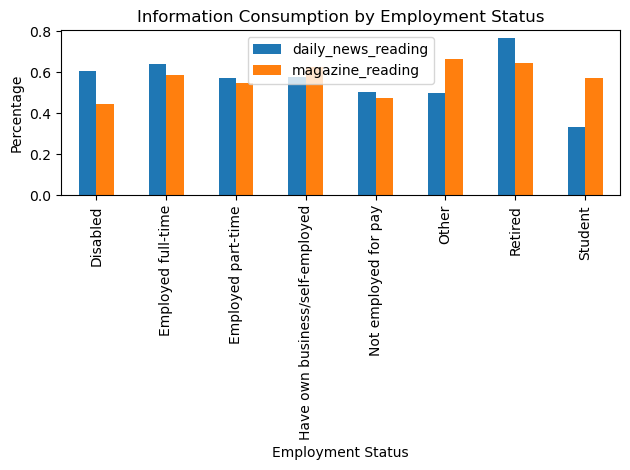

In [10]:
info_consumption = pd.DataFrame({
        'daily_news_reading': df.groupby('employment_status')['read_daily_news'].apply(lambda x: (x == 'Yes').mean()),
        'magazine_reading': df.groupby('employment_status')['read_magazines_journals'].apply(lambda x: (x == 'Yes').mean()),
        'book_reading': df.groupby('employment_status')['books_read_last_12m'].mean()
    }).reset_index()
    
# Visualization
plt.figure(figsize=(10, 6))
info_consumption.plot(x='employment_status', y=['daily_news_reading', 'magazine_reading'], kind='bar')
plt.title('Information Consumption by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()